In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
import PIL.Image as Image
import time
import numpy as np
import matplotlib.pyplot as plt
import zipfile

train_dir = 'monet_jpg'
test_dir = 'photo_jpg'

In [16]:
train_images=os.listdir(train_dir)
test_images=os.listdir(test_dir)

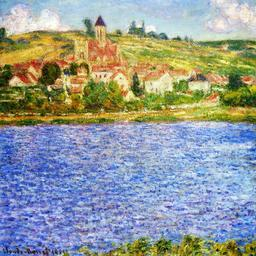

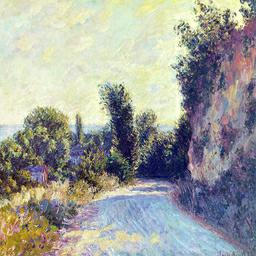

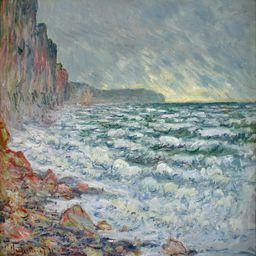

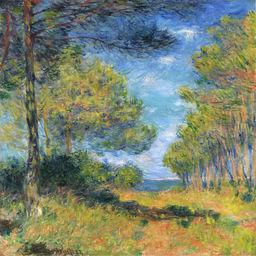

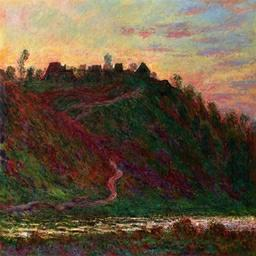

In [17]:
from PIL import Image
from IPython.display import display
for i in range(0,5):
    im=Image.open(os.path.join(train_dir, train_images[i]))
    display(im)
       

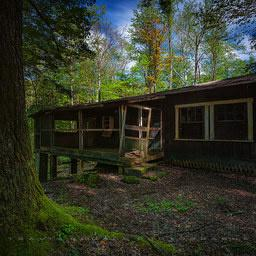

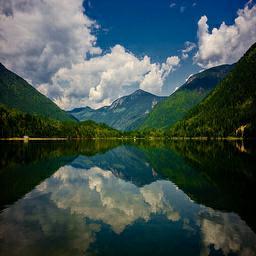

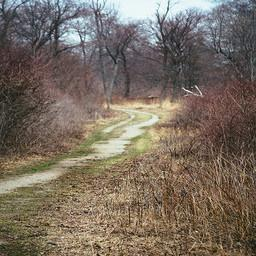

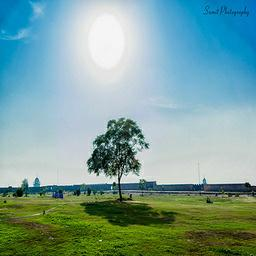

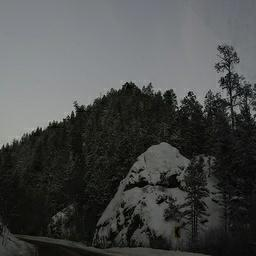

In [18]:
for i in range(0,5):
    im=Image.open(os.path.join(test_dir, test_images[i]))
    display(im)

In [19]:
tr_im=Image.open(os.path.join(train_dir, train_images[0]))
print("Here is the information about training images")
print("size of image is", tr_im.size)
print("mode of image is", tr_im.mode)
print("No. of bands in image are",len(tr_im.getbands()))
       

Here is the information about training images
size of image is (256, 256)
mode of image is RGB
No. of bands in image are 3


In [20]:
im=Image.open(os.path.join(test_dir, test_images[0]))
print("Here is the information about test images")
print("size of image is", im.size)
print("mode of image is",im.mode)
print("No. of bands in image are",len(im.getbands()))

Here is the information about test images
size of image is (256, 256)
mode of image is RGB
No. of bands in image are 3


In [38]:
def plot_color_histogram(image):
    plt.figure(figsize=(12, 4))
    r, g, b = image.split()
    plt.subplot(131)
    plt.hist(r.getdata(), color='red', alpha=0.7, rwidth=0.8)
    plt.title('Red Channel')
    plt.subplot(132)
    plt.hist(g.getdata(), color='green', alpha=0.7, rwidth=0.8)
    plt.title('Green Channel')
    plt.subplot(133)
    plt.hist(b.getdata(), color='blue', alpha=0.7, rwidth=0.8)
    plt.title('Blue Channel')
    plt.tight_layout()
    plt.show()



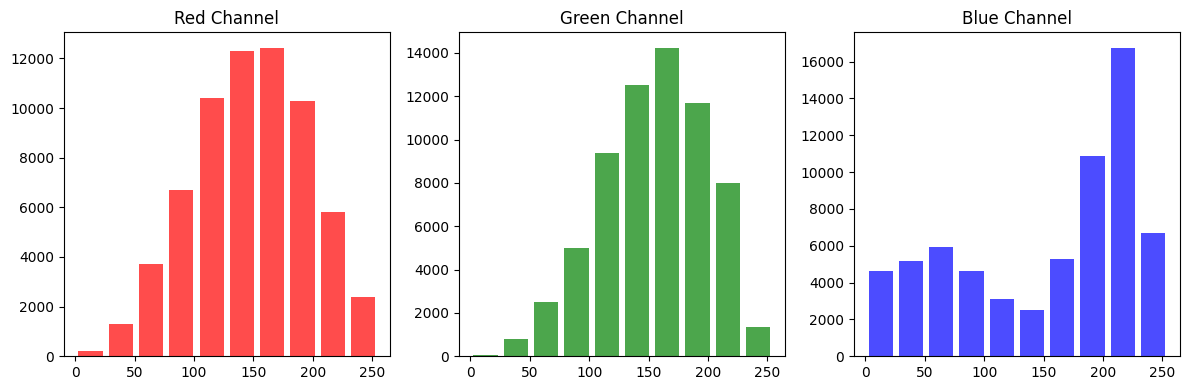

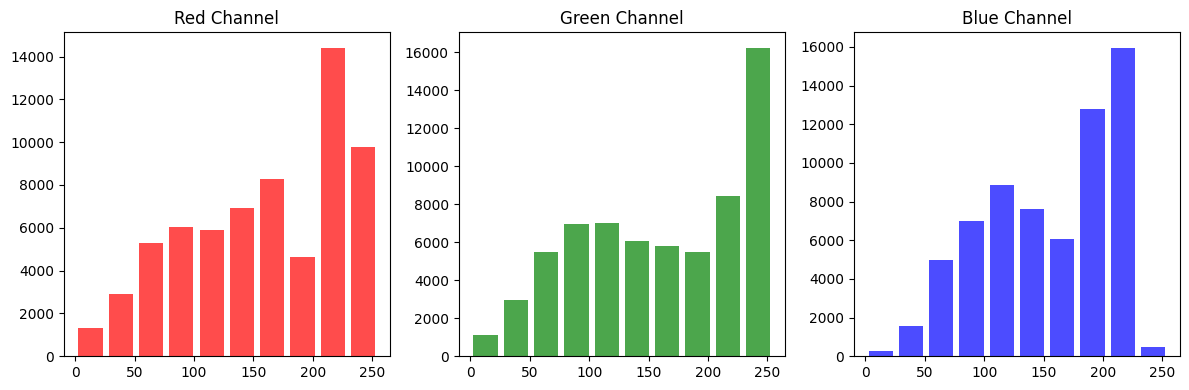

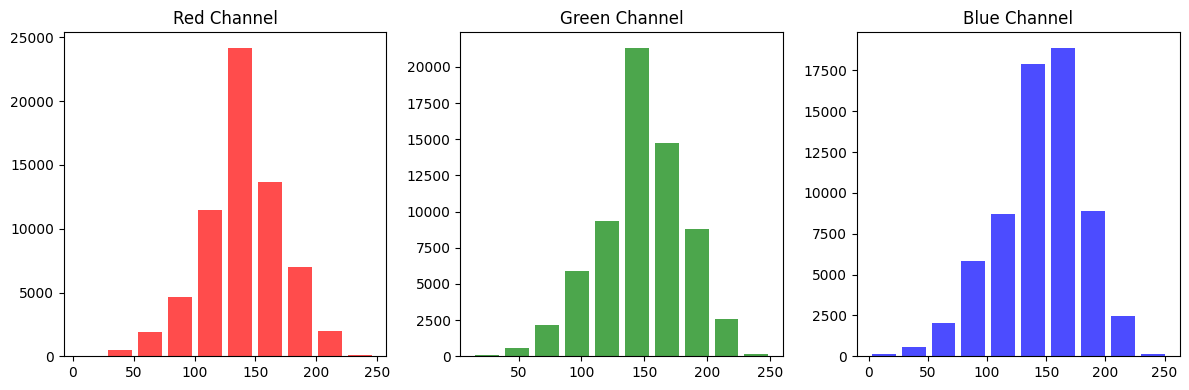

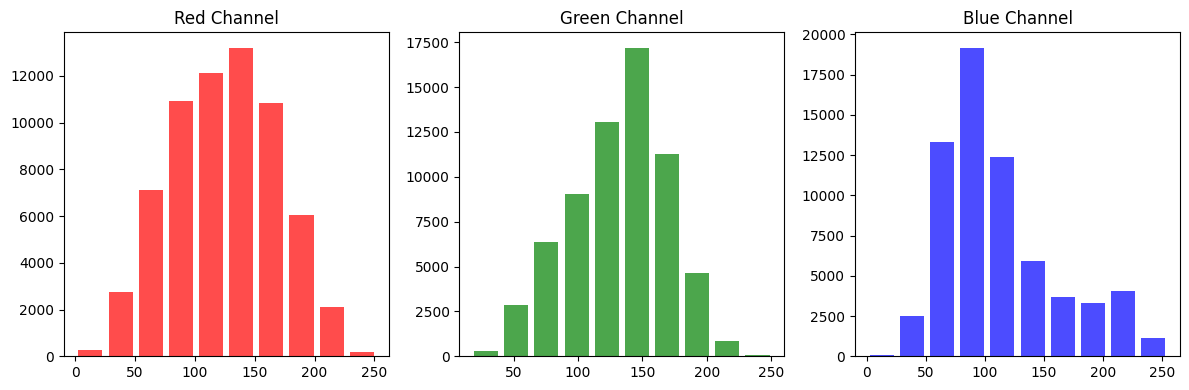

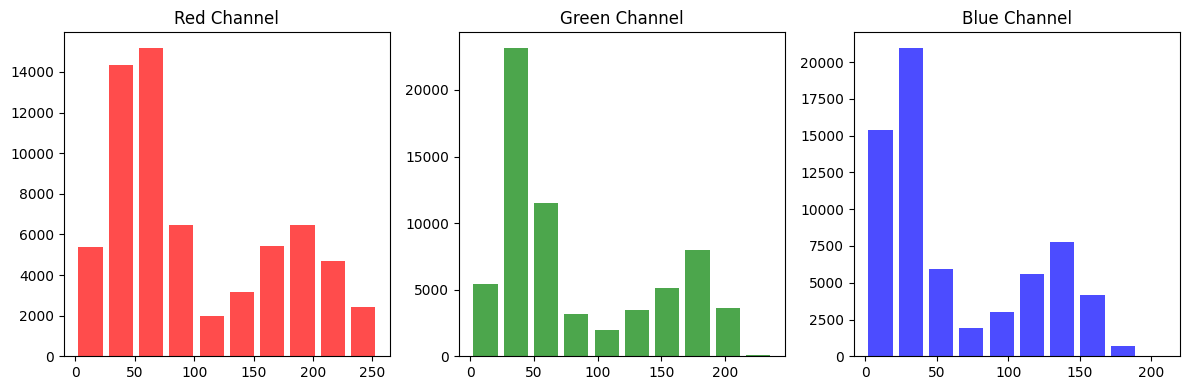

In [39]:
for i in range(0,5):
    im=Image.open(os.path.join(train_dir, train_images[i]))
    #im = np.array(im)
    plot_color_histogram(im)
       

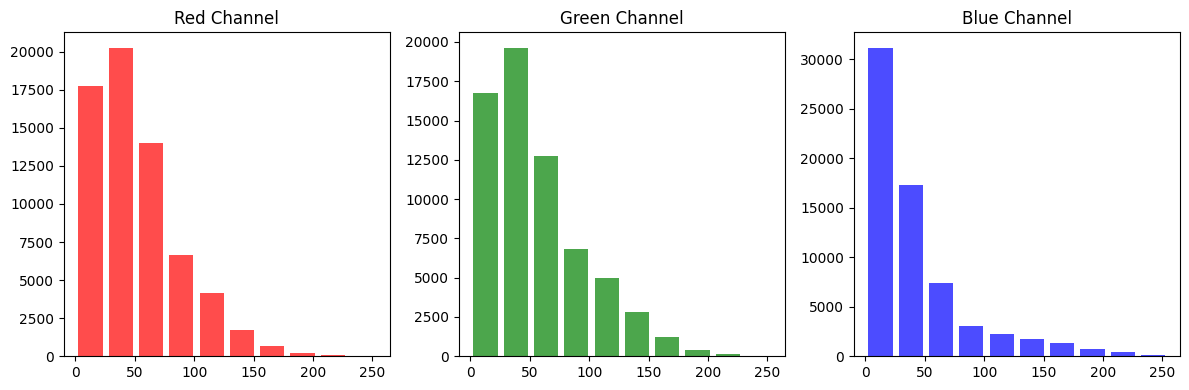

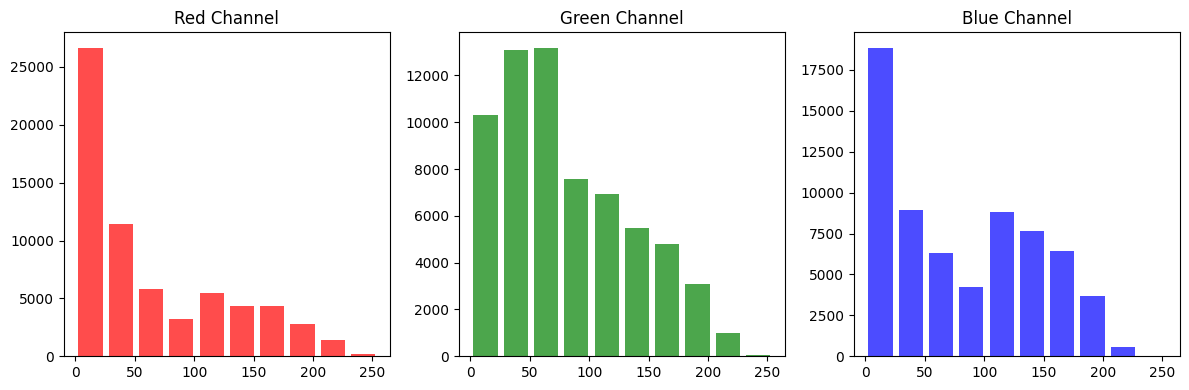

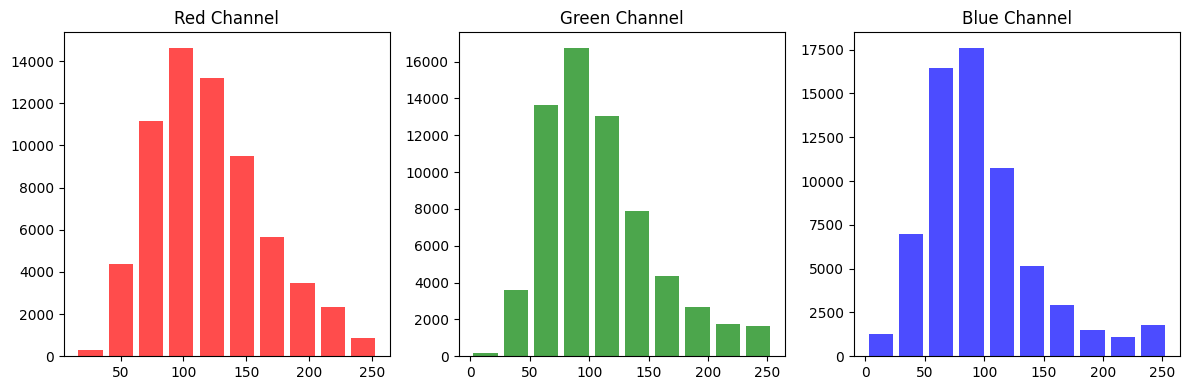

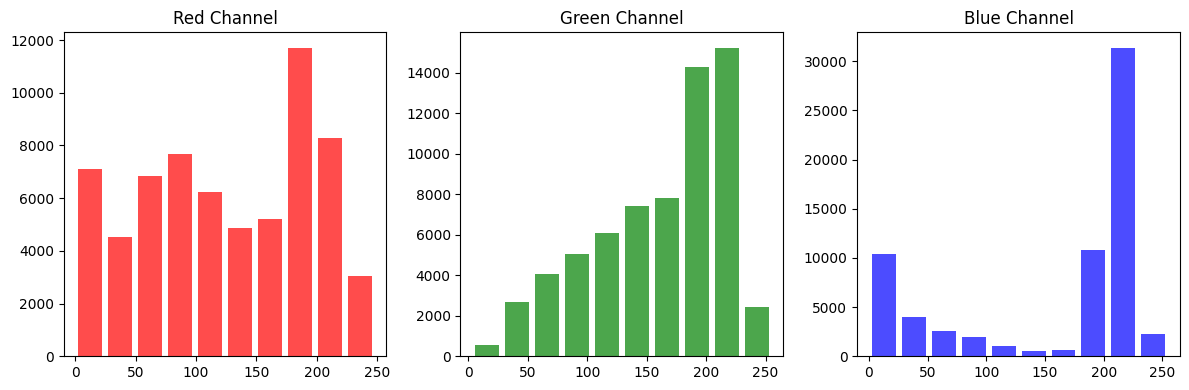

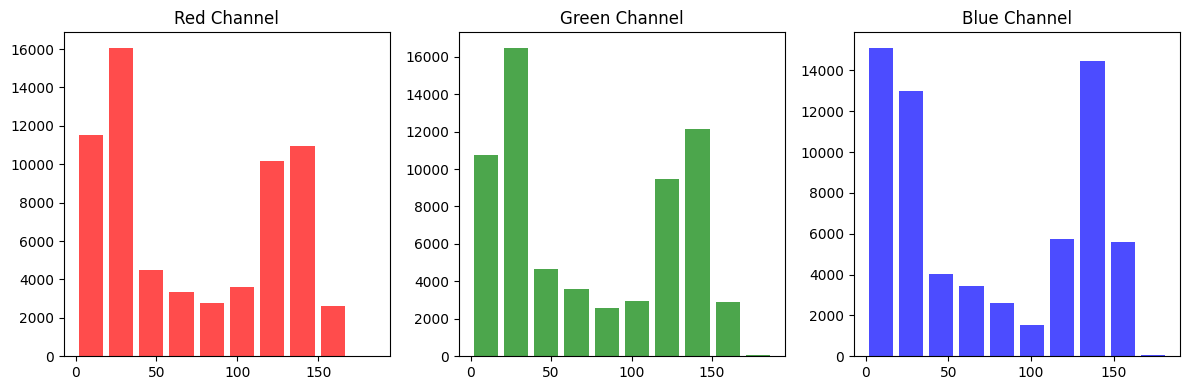

In [40]:
for i in range(0,5):
    im=Image.open(os.path.join(test_dir, test_images[i]))
    #im = np.array(im)
    plot_color_histogram(im)

In [7]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, data_transform=None):
        self.data_dir = data_dir
        self.data_transform = data_transform
        self.image_list = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        label = 0  
        image_path = os.path.join(self.data_dir, self.image_list[index])
        image = Image.open(image_path)

        if self.data_transform:
            image = self.data_transform(image)
        return image, label



In [8]:
class CustomGenerator(nn.Module):
    def __init__(self):
        super(CustomGenerator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class CustomDiscriminator(nn.Module):
    def __init__(self):
        super(CustomDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [9]:
custom_generator = CustomGenerator()
custom_discriminator = CustomDiscriminator()

criterion = nn.BCEWithLogitsLoss()
generator_optimizer = optim.Adam(custom_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(custom_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_dataset = CustomImageDataset(test_dir, data_transform)
train_dataset = CustomImageDataset(train_dir,data_transform)

In [10]:
def train_discriminator(discriminator, real_data_1, real_data_2):
    discriminator_optimizer.zero_grad()
    real_1_output = discriminator(real_data_1)
    real_1_loss = criterion(real_1_output, torch.ones_like(real_1_output))
    real_2_output = discriminator(real_data_2)
    real_2_loss = criterion(real_2_output, torch.ones_like(real_2_output))
    loss = real_1_loss + real_2_loss
    loss.backward()
    discriminator_optimizer.step()
    return loss.item()

def train_generator(generator, discriminator, input_data_1, input_data_2):
    generator_optimizer.zero_grad()
    f1 = generator(input_data_1)
    f2 = generator(input_data_2)
    f1_loss = criterion(discriminator(f1), torch.ones_like(f1))
    f2_loss = criterion(discriminator(f2), torch.ones_like(f2))
    loss = f1_loss + f2_loss
    loss.backward()
    generator_optimizer.step()
    return loss.item()
def process_and_save_images(test_dir, generator, output_folder='output_images'):
    os.makedirs(output_folder, exist_ok=True)

    for i, image_file in enumerate(os.listdir(test_dir)):
        input_image = np.array(Image.open(os.path.join(test_dir, image_file)))

        input_tensor = torch.from_numpy(np.transpose(input_image, (2, 0, 1))).float()
        normalized = (input_tensor - input_tensor.mean()) / input_tensor.std()
        output = generator(normalized)
        denormalized = output * input_tensor.std() + input_tensor.mean()
        output_tensor = np.transpose(denormalized.detach().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
        output_image = Image.fromarray(output_tensor)
        filename = f'image_{i}.jpg'
        file_path = os.path.join(output_folder, filename)
        output_image.save(file_path)
        print(f'Image {i} generated and saved to {output_folder}')


In [11]:
num_epochs = 5
generator_optimizer = optim.Adam(custom_generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(custom_discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, (real_data_1, real_data_2) in enumerate(zip(test_dataset, train_dataset)):
        start = time.time()
        input_data_1 = real_data_1[0]
        input_data_2 = real_data_2[0]
        D_real_loss = train_discriminator(custom_discriminator, input_data_1, input_data_2)
        D_fake_loss = train_discriminator(custom_discriminator, custom_generator(input_data_1), custom_generator(input_data_2))
        D_loss = D_real_loss + D_fake_loss
        G_loss = train_generator(custom_generator, custom_discriminator, input_data_1, input_data_2)
        print("Epoch: {}/{}, Step: {}/{}, Discriminator Loss: {:.10f}, Generator Loss: {:.10f}, Time: {:.2f} Sec".format(epoch+1, num_epochs, i+1, min(len(test_dataset), len(train_dataset)), D_loss, G_loss, time.time()-start))



Epoch: 1/5, Step: 1/300, Discriminator Loss: 2.8263113499, Generator Loss: 1.4070670605, Time: 5.39 Sec
Epoch: 1/5, Step: 2/300, Discriminator Loss: 2.8099248409, Generator Loss: 1.4005506039, Time: 5.26 Sec
Epoch: 1/5, Step: 3/300, Discriminator Loss: 2.7949805260, Generator Loss: 1.3941829205, Time: 4.98 Sec
Epoch: 1/5, Step: 4/300, Discriminator Loss: 2.7741509676, Generator Loss: 1.3858077526, Time: 5.07 Sec
Epoch: 1/5, Step: 5/300, Discriminator Loss: 2.7582703829, Generator Loss: 1.3762176037, Time: 5.34 Sec
Epoch: 1/5, Step: 6/300, Discriminator Loss: 2.7256381512, Generator Loss: 1.3636562824, Time: 6.02 Sec
Epoch: 1/5, Step: 7/300, Discriminator Loss: 2.6907806396, Generator Loss: 1.3465590477, Time: 6.75 Sec
Epoch: 1/5, Step: 8/300, Discriminator Loss: 2.6579881907, Generator Loss: 1.3253014088, Time: 6.26 Sec
Epoch: 1/5, Step: 9/300, Discriminator Loss: 2.5782411098, Generator Loss: 1.2925688028, Time: 5.95 Sec
Epoch: 1/5, Step: 10/300, Discriminator Loss: 2.4836937189, Gene

In [12]:
process_and_save_images(test_dir, custom_generator,output_folder='output_images_0.0001')

Image 0 generated and saved to output_images_0.0001
Image 1 generated and saved to output_images_0.0001
Image 2 generated and saved to output_images_0.0001
Image 3 generated and saved to output_images_0.0001
Image 4 generated and saved to output_images_0.0001
Image 5 generated and saved to output_images_0.0001
Image 6 generated and saved to output_images_0.0001
Image 7 generated and saved to output_images_0.0001
Image 8 generated and saved to output_images_0.0001
Image 9 generated and saved to output_images_0.0001
Image 10 generated and saved to output_images_0.0001
Image 11 generated and saved to output_images_0.0001
Image 12 generated and saved to output_images_0.0001
Image 13 generated and saved to output_images_0.0001
Image 14 generated and saved to output_images_0.0001
Image 15 generated and saved to output_images_0.0001
Image 16 generated and saved to output_images_0.0001
Image 17 generated and saved to output_images_0.0001
Image 18 generated and saved to output_images_0.0001
Ima

In [13]:
num_epochs = 5
generator_optimizer = optim.Adam(custom_generator.parameters(), lr=0.001, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(custom_discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, (real_data_1, real_data_2) in enumerate(zip(test_dataset, train_dataset)):
        start = time.time()
        input_data_1 = real_data_1[0]
        input_data_2 = real_data_2[0]
        D_real_loss = train_discriminator(custom_discriminator, input_data_1, input_data_2)
        D_fake_loss = train_discriminator(custom_discriminator, custom_generator(input_data_1), custom_generator(input_data_2))
        D_loss = D_real_loss + D_fake_loss
        G_loss = train_generator(custom_generator, custom_discriminator, input_data_1, input_data_2)
        print("Epoch: {}/{}, Step: {}/{}, Discriminator Loss: {:.10f}, Generator Loss: {:.10f}, Time: {:.2f} Sec".format(epoch+1, num_epochs, i+1, min(len(test_dataset), len(train_dataset)), D_loss, G_loss, time.time()-start))



Epoch: 1/5, Step: 1/300, Discriminator Loss: 0.0000002207, Generator Loss: 0.0000000000, Time: 4.40 Sec
Epoch: 1/5, Step: 2/300, Discriminator Loss: 0.0000011367, Generator Loss: 0.0000000000, Time: 4.25 Sec
Epoch: 1/5, Step: 3/300, Discriminator Loss: 0.0000001111, Generator Loss: 0.0000000000, Time: 4.46 Sec
Epoch: 1/5, Step: 4/300, Discriminator Loss: 0.0000000166, Generator Loss: 0.0000000000, Time: 4.26 Sec
Epoch: 1/5, Step: 5/300, Discriminator Loss: 0.0000000665, Generator Loss: 0.0000000000, Time: 4.27 Sec
Epoch: 1/5, Step: 6/300, Discriminator Loss: 0.0000000331, Generator Loss: 0.0000000000, Time: 4.34 Sec
Epoch: 1/5, Step: 7/300, Discriminator Loss: 0.0000000094, Generator Loss: 0.0000000000, Time: 4.36 Sec
Epoch: 1/5, Step: 8/300, Discriminator Loss: 0.0000000024, Generator Loss: 0.0000000000, Time: 4.28 Sec
Epoch: 1/5, Step: 9/300, Discriminator Loss: 0.0000000123, Generator Loss: 0.0000000000, Time: 4.31 Sec
Epoch: 1/5, Step: 10/300, Discriminator Loss: 0.0000000090, Gene

In [14]:
process_and_save_images(test_dir, custom_generator,output_folder='output_images_0.001')

Image 0 generated and saved to output_images_0.001
Image 1 generated and saved to output_images_0.001
Image 2 generated and saved to output_images_0.001
Image 3 generated and saved to output_images_0.001
Image 4 generated and saved to output_images_0.001
Image 5 generated and saved to output_images_0.001
Image 6 generated and saved to output_images_0.001
Image 7 generated and saved to output_images_0.001
Image 8 generated and saved to output_images_0.001
Image 9 generated and saved to output_images_0.001
Image 10 generated and saved to output_images_0.001
Image 11 generated and saved to output_images_0.001
Image 12 generated and saved to output_images_0.001
Image 13 generated and saved to output_images_0.001
Image 14 generated and saved to output_images_0.001
Image 15 generated and saved to output_images_0.001
Image 16 generated and saved to output_images_0.001
Image 17 generated and saved to output_images_0.001
Image 18 generated and saved to output_images_0.001
Image 19 generated and

In [ ]:
criterion = lambda fake_logits, real_logits: torch.mean(fake_logits) - torch.mean(real_logits)
generator_optimizer = optim.Adam(custom_generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(custom_discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_dataset = CustomImageDataset(test_dir, data_transform)
train_dataset = CustomImageDataset(train_dir,data_transform)

In [ ]:
for epoch in range(num_epochs):
    for i, (real_data_1, real_data_2) in enumerate(zip(test_dataset, train_dataset)):
        start = time.time()
        input_data_1 = real_data_1[0]
        input_data_2 = real_data_2[0]
        D_real_loss = train_discriminator(custom_discriminator, input_data_1, input_data_2)
        D_fake_loss = train_discriminator(custom_discriminator, custom_generator(input_data_1), custom_generator(input_data_2))
        D_loss = D_real_loss + D_fake_loss
        G_loss = train_generator(custom_generator, custom_discriminator, input_data_1, input_data_2)
        print("Epoch: {}/{}, Step: {}/{}, Discriminator Loss: {:.10f}, Generator Loss: {:.10f}, Time: {:.2f} Sec".format(epoch+1, num_epochs, i+1, min(len(test_dataset), len(train_dataset)), D_loss, G_loss, time.time()-start))


In [ ]:
process_and_save_images(test_dir, custom_generator,output_folder='output_images_Wasserstein GAN loss')